## Following the tutorial at:
http://strimas.com/spatial/hexagonal-grids/

In [3]:
suppressMessages(library(dplyr))
library(tidyr)
library(sp)
suppressMessages(library(raster))
suppressMessages(library(rgeos))
library(rgbif)
library(viridis)
library(gridExtra)
library(rasterVis)
set.seed(1)

Need to make the path... this is where it is saving the files to.

In [4]:
study_area <- getData("GADM", country = "USA", level = 0, path="data/hex-grids") %>%
    disaggregate %>% 
    geometry

In [5]:
study_area <- sapply(study_area@polygons, slot, "area") %>% 
  {which(. == max(.))} %>% 
  study_area[.]

In [6]:
clip_list <- c(-80, -70, 35, 45)
study_area <- crop(study_area, clip_list)

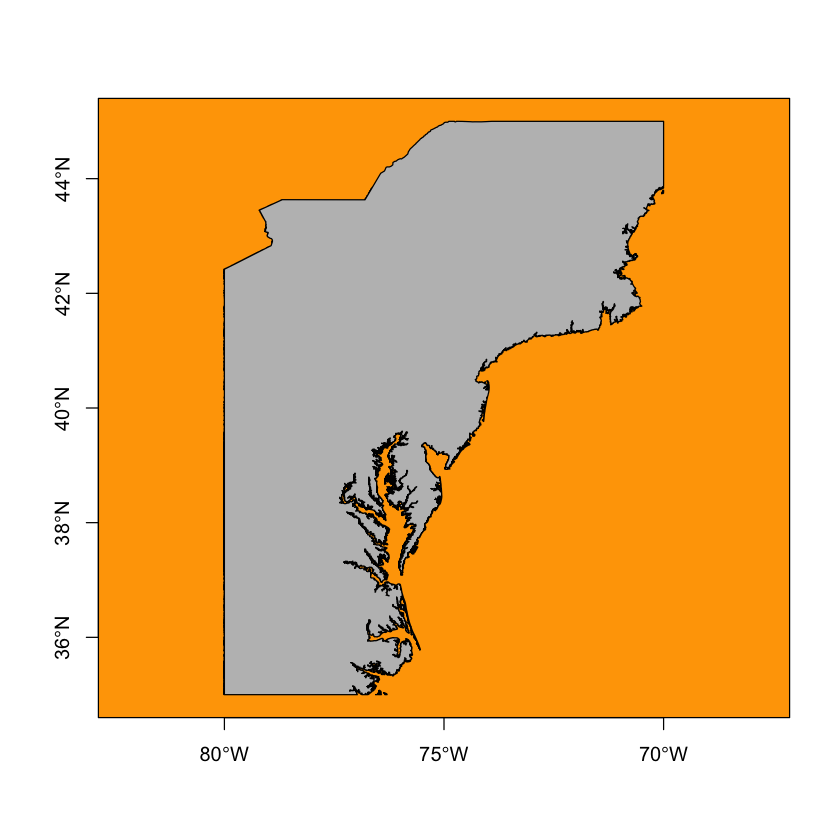

In [7]:
#plot(study_area, col="gray", bg="orange", axes=TRUE)

### Overlay hexagonal grids

In [8]:
source("make_grid.r")

In [9]:
# Convert to raster
study_area_utm <- CRS("+proj=utm +zone=14 +datum=WGS84 +units=km +no_defs") %>% 
  spTransform(study_area, .)

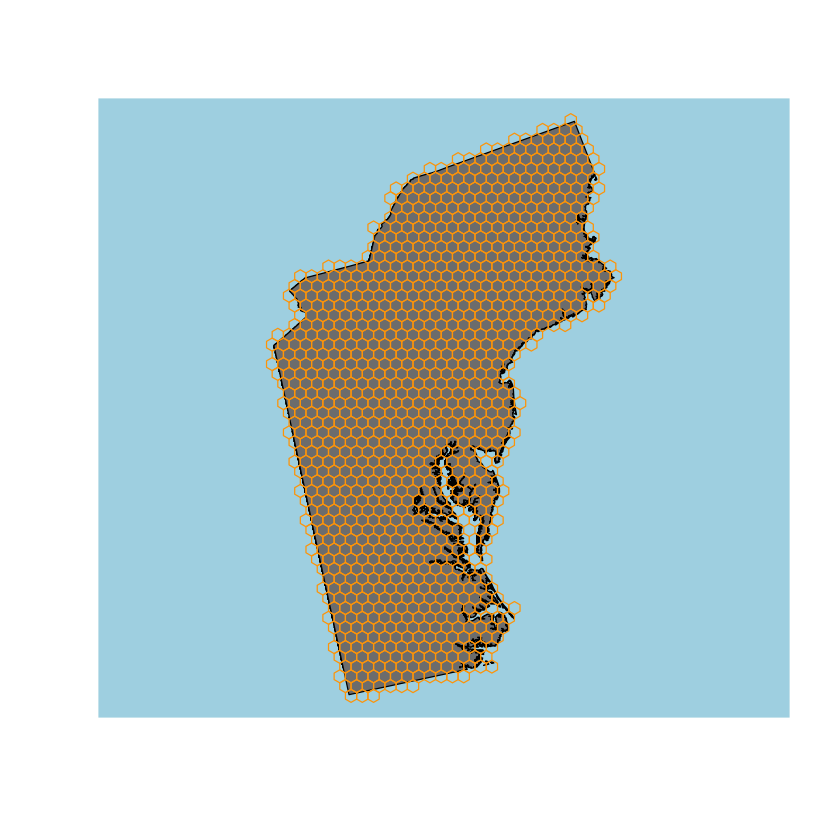

In [10]:
hex_grid <- make_grid(study_area_utm, type = "hexagonal", cell_area = 625, clip = FALSE)
plot(study_area_utm, col = "grey50", bg = "light blue", axes = FALSE)
plot(hex_grid, border = "orange", add = TRUE)


## Ebird test

In [10]:
ebird_key <- "4fa7b334-ce0d-4e88-aaae-2e0c138d049e"
bird_families <- c("Trochilidae", "Corvidae")
families <- data_frame(family = bird_families) %>% 
  group_by(family) %>% 
  do(name_suggest(q = .$family, rank = "family")) %>% 
  filter(family == canonicalName) %>% 
  dplyr::select(family, key)
gb <- occ_search(taxonKey = families$key, country = "US", datasetKey = ebird_key, 
                 limit = 1000, return = "data",
                 fields = c("family", "species", "decimalLatitude", "decimalLongitude"),
                 hasCoordinate = TRUE, hasGeospatialIssue = FALSE) %>% 
  bind_rows %>% 
  rename(lng = decimalLongitude, lat = decimalLatitude) %>% 
  as.data.frame

In [11]:
coordinates(gb) <- ~ lng + lat
projection(gb) <- projection(study_area)
gb <- spTransform(gb, projection(study_area_utm)) #needs to be spTranformed layer (studyareautm)

In [12]:
fill_missing <- expand.grid(id = row.names(hex_grid), 
                            family = bird_families, stringsAsFactors = FALSE)

In [13]:
point_density <- over(hex_grid, gb, returnList = TRUE) %>% 
  plyr::ldply(.fun = function(x) x, .id = "id") %>%
  mutate(id = as.character(id)) %>% 
  count(id, family) %>% 
  left_join(fill_missing, ., by = c("id", "family")) %>%
  # log transform
  mutate(n = ifelse(is.na(n), -1, log10(n))) %>% 
  spread(family, n, fill = -1) %>% 
  SpatialPolygonsDataFrame(hex_grid, .)

### This plots the data but need to mess with axes.

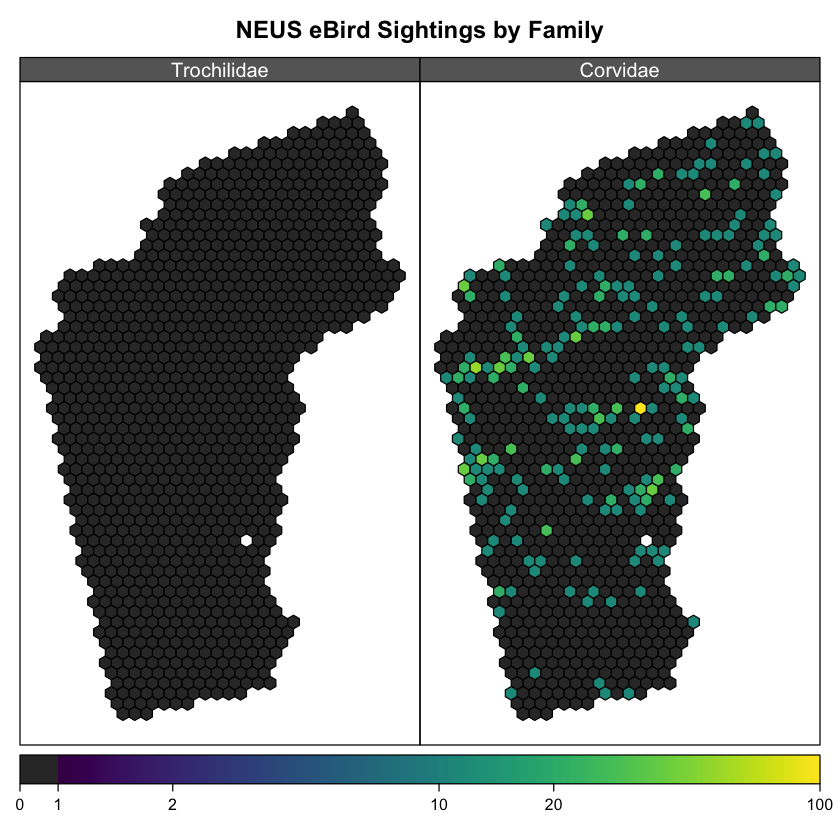

In [14]:
spplot(point_density, bird_families,
       main = "NEUS eBird Sightings by Family",
       col.regions = c("grey20", viridis(255)),
       colorkey = list(
         space = "bottom",
         at = c(-0.1, seq(0, log10(100), length.out = 255)),
         labels = list(
           at = c(-0.1, log10(c(1, 2, 10, 20, 100))),
           labels = c(0, 1, 2, 10, 20, 100)
           )
         ),
       xlim = bbexpand(bbox(point_density)[1, ], 0.04), 
       ylim = bbexpand(bbox(point_density)[2, ], 0.04),
       par.strip.text = list(col = "white"),
       par.settings = list(
         strip.background = list(col = "grey40"))
       )

## Test to see if I can get Ecuador data from GADM

In [ ]:
#ecuador <- getData(name = "GADM", country = "USA", level = 0, 
#                   path = "data/hex-grids/") %>% 
#  disaggregate %>% 
#  geometry
## project
#ecuador <- crop(ecuador, clip_list)
#ecuador <- spTransform(ecuador, CRS("+proj=utm +zone=17 +datum=WGS84 +units=km +no_defs"))
#hex_ecu <- make_grid(ecuador, type = "hexagonal", cell_area = 625, clip = FALSE)

In [23]:
srtm <- getData('alt', country = 'US', path = "data/hex-grids/")

returning a list of RasterLayer objects


In [34]:
crop(srtm, y=hex_grid)

ERROR: Error in (function (classes, fdef, mtable) : unable to find an inherited method for function ‘crop’ for signature ‘"list"’
